In [636]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
companies = pd.read_csv("companies.txt", sep="\t", encoding = "ISO-8859-1")
# companies.head()
print(companies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
permalink        66368 non-null object
name             66367 non-null object
homepage_url     61310 non-null object
category_list    63220 non-null object
status           66368 non-null object
country_code     59410 non-null object
state_code       57821 non-null object
region           58338 non-null object
city             58340 non-null object
founded_at       51147 non-null object
dtypes: object(10)
memory usage: 5.1+ MB
None


In [51]:
rounds2 = pd.read_csv("rounds2.csv", sep=",", encoding = "ISO-8859-1")
#rounds2.head()
print(rounds2.info())
print(len(rounds2['company_permalink'].unique().tolist()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB
None
90247


In [271]:
companies['permalink'] = companies['permalink'].str.lower()
companies['permalink'] = companies['permalink'].str.strip()
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
rounds2['company_permalink'] = rounds2['company_permalink'].str.strip()
#print(rounds2.info())
#print(len(rounds2['company_permalink'].unique().tolist()))

rounds2Companies = set(rounds2['company_permalink'])
companiesSet = set(companies['permalink'])
diff = rounds2Companies - companiesSet
#print(list(diff))
#print('Difference:', len(list(diff)))
master_frame = pd.merge(rounds2,companies,left_on='company_permalink', right_on='permalink',how='outer')
#print(master_frame.info())
#print(master_frame.head())
# **************Check point 2***************************

df_by_fundingType = master_frame.groupby('funding_round_type')
#print(round(df_by_fundingType['raised_amount_usd'].mean(),2))
average_funding_by_funding_type = pd.DataFrame(df_by_fundingType['raised_amount_usd'].mean())
#print(average_funding_by_funding_type.info())
best_funding_type = average_funding_by_funding_type.loc[(average_funding_by_funding_type.raised_amount_usd >= 5000000.00) & (average_funding_by_funding_type.raised_amount_usd <=15000000.00)]
#print(best_funding_type.info())



#df_ventures = master_frame.loc[(master_frame.funding_round_type =='venture') & (master_frame.raised_amount_usd.notnull()) , ['funding_round_type', 'raised_amount_usd']]
#round((df_ventures.raised_amount_usd.sum()/len(df_ventures.index)), 2)
#print( round( df_ventures.raised_amount_usd.mean(),2))

#df_angel = master_frame.loc[(master_frame.funding_round_type =='angel') & (master_frame.raised_amount_usd.notnull()) , ['funding_round_type', 'raised_amount_usd']]
#print( round( df_angel.raised_amount_usd.mean(),2))

#df_seed = master_frame.loc[(master_frame.funding_round_type =='seed') & (master_frame.raised_amount_usd.notnull()) , ['funding_round_type', 'raised_amount_usd']]
#print( round( df_seed.raised_amount_usd.mean(),2))

#df_private_equity = master_frame.loc[(master_frame.funding_round_type =='private_equity') & (master_frame.raised_amount_usd.notnull()) , ['funding_round_type', 'raised_amount_usd']]
#print( round(df_private_equity.raised_amount_usd.mean(),2))

# **********************check point 3 *******************

df_master_best_fund = master_frame.loc[(master_frame.funding_round_type =='venture') &(master_frame.country_code.notnull() & (master_frame.raised_amount_usd.notnull())) ,['country_code','raised_amount_usd']]
#print(df_master_best_fund)
top9_highest_total_funding_group =  df_master_best_fund.groupby('country_code')['raised_amount_usd'].sum().nlargest(9)
top9_highest_total_funding_country = list(top9_highest_total_funding_group.index)
#print(top9_highest_total_funding_country)
top9 = master_frame.loc[(master_frame.funding_round_type =='venture') &(master_frame['country_code'].isin(top9_highest_total_funding_country))]
                        
#print(top9.head())

#print(top9.category_list)
#pd.concat([df[[0]], df[1].str.split(', ', expand=True)], axis=1)
top9['primary_sector'] = top9['category_list'].str.split('|', n = 2, expand = True)[0]
#print(top9.primary_sector)
#print( top9[(top9.primary_sector.isnull())].primary_sector)

#******************Check point 4 *****************

df_mapping = pd.read_csv("mapping.csv", sep=",", encoding = "ISO-8859-1")
#df_mapping = df_mapping.loc[(df_mapping.category_list.notnull())]
df_mapping = pd.melt(df_mapping, id_vars=['category_list'])
#print(df_mapping[(df_mapping.variable=='Blanks')].iloc[0])

df_mapping = df_mapping[(df_mapping.value ==1)]
#drop value column and rename category_list and variable to primary_sector and main sector
df_mapping.drop('value', axis = 1, inplace = True)
df_mapping.rename(columns={'category_list':'primary_sector', 'variable':'main_sector'}, inplace = True)
#print(df_mapping)


# merging maping and top9 df
#using left join to retain all records of top9
top9 = pd.merge(top9, df_mapping, how = 'left', on = 'primary_sector')
#print(top9)

# clean data

# map all null main sector to others
top9.loc[(top9['main_sector'].isnull(),['main_sector'])] = 'Others'
#print(len(top9[top9['main_sector'].isnull()]))
#print(top9)

df_D1 = top9.loc[(top9.country_code == 'USA') & (( top9.funding_round_type=='venture')&(top9.raised_amount_usd >= 5000000.00) & (top9.raised_amount_usd <=15000000.00))]
df_D2 = top9.loc[(top9.country_code == 'GBR') & (( top9.funding_round_type=='venture')&(top9.raised_amount_usd >= 5000000.00) & (top9.raised_amount_usd <=15000000.00))]
df_D3 = top9.loc[(top9.country_code == 'IND') & (( top9.funding_round_type=='venture')&(top9.raised_amount_usd >= 5000000.00) & (top9.raised_amount_usd <=15000000.00))]



df_D1_by_sector = df_D1.groupby('main_sector')['raised_amount_usd'].agg(('sum','count'))
df_D1_by_sector.rename(columns={'sum':'Sum of Investment','count':'Count of Investment'}, inplace=True)
df_D1 = pd.merge(df_D1,df_D1_by_sector,on='main_sector')
#print(df_D1_by_sector)

df_D2_by_sector = df_D2.groupby('main_sector')['raised_amount_usd'].agg(('sum','count'))
df_D2_by_sector.rename(columns={'sum':'Sum of Investment','count':'Count of Investment'}, inplace=True)
df_D2 = pd.merge(df_D2,df_D2_by_sector,on='main_sector')

#print(df_D2)

df_D3_by_sector = df_D3.groupby('main_sector')['raised_amount_usd'].agg(('sum','count'))
df_D3_by_sector.rename(columns={'sum':'Sum of Investment','count':'Count of Investment'}, inplace=True)
df_D3 = pd.merge(df_D3,df_D3_by_sector,on='main_sector')

#print(df_D3)

# concatinating d1, d2 and d3
top3 = pd.concat([df_D1, df_D2, df_D3], axis = 0, ignore_index = True, sort = False)
#print(top3)
#Total number of Investments (count)
#top3.groupby('country_code')['raised_amount_usd'].count()

#Total amount of investment (USD)
#top3.groupby('country_code')['raised_amount_usd'].sum()

#Top Sector name (no. of investment-wise)
top3.groupby(['country_code','main_sector'])['main_sector'].count()
#top3.groupby(['country_code','main_sector'])['main_sector'].sum()

#For point 3 (top sector count-wise), which company received the highest investment?
highest_investment_c1 = top3.loc[(top3.country_code == 'USA')& (top3.main_sector == 'Cleantech / Semiconductors')]
highest_investment_c1_company = highest_investment_c1.groupby(['permalink','name']).raised_amount_usd.sum().sort_values(ascending = False);
#print(highest_investment_c1_company)


highest_investment_c2_company = pd.DataFrame(top3.loc[(top3.country_code == 'GBR')& (top3.main_sector == 'Social, Finance, Analytics, Advertising')].groupby(['permalink','name']).raised_amount_usd.sum().sort_values(ascending = False))
#print(highest_investment_c2_company)

highest_investment_c3_company = pd.DataFrame(top3.loc[(top3.country_code == 'IND')& (top3.main_sector == 'Social, Finance, Analytics, Advertising')].groupby(['permalink','name']).raised_amount_usd.sum().sort_values(ascending = False))
#print(highest_investment_c3_company)


C:\Users\shash\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [415]:
# Plot your chart here 
total_inv_by_fund_type = master_frame.groupby('funding_round_type', as_index=False)['raised_amount_usd'].sum()
total_inv_by_fund_type.rename(columns={'raised_amount_usd':'Sum of Investment'}, inplace=True)
#print(total_inv_by_fund_type)

avg_inv_by_fund_type = master_frame.groupby('funding_round_type', as_index=False)['raised_amount_usd'].mean()
avg_inv_by_fund_type.rename(columns={'raised_amount_usd':'Mean of Investment'}, inplace=True)
#print(avg_inv_by_fund_type)



fund_type = pd.merge(total_inv_by_fund_type, avg_inv_by_fund_type, on='funding_round_type')
fund_type2 = fund_type.loc[(~fund_type.funding_round_type.isin(['venture','seed','private_equity']))]
fund_type = fund_type.loc[(fund_type.funding_round_type.isin(['venture','seed','private_equity']))]
fund_type = fund_type.append([{'funding_round_type':'Remaining','Sum of Investment': fund_type2['Sum of Investment'].sum(),'Mean of Investment':0}])
#print(fund_type2)
#print(fund_type)






   funding_round_type  Sum of Investment  Mean of Investment
8      private_equity   141925436105.000        73308593.029
11               seed    16989864181.000          719817.997
13            venture   590126216876.000        11748949.129
0           Remaining   241083567973.000               0.000


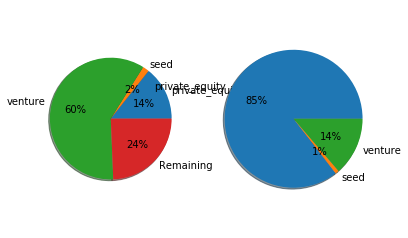

In [414]:
import matplotlib.pyplot as plt
# Data to plot
labels = fund_type.funding_round_type 
sizes = list(fund_type['Sum of Investment'])

sizes1 = list(fund_type['Mean of Investment'])[0:-1]
labels1 = list(fund_type.funding_round_type)[0:-1]
#colors = ['gold', 'yellowgreen', 'lightcoral',]
#explode = (0, 0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.subplot(121)
plt.pie(sizes, labels=labels,autopct='%1.0f%%',
        shadow=True)
 
#plt.axis('equal')

plt.subplot(122)
plt.pie(sizes1, labels=labels1,autopct='%1.0f%%',shadow=True)
 
plt.axis('equal')



plt.show()




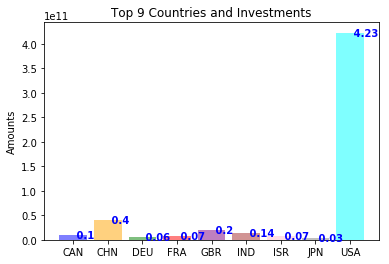

In [635]:
plot_top9 = top9.loc[(top9.funding_round_type == 'venture')]
plot_top9 = plot_top9.groupby('country_code',as_index=False).raised_amount_usd.sum()
#print(plot_top9)

objects = plot_top9.country_code
y_pos = np.arange(len(objects))
performance = list( plot_top9.raised_amount_usd)
colors =  ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray','cyan']
plt.bar(y_pos, performance, color=colors, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Amounts')
plt.title('Top 9 Countries and Investments')

for i, v in enumerate(plot_top9.raised_amount_usd):
    plt.text(i, v, " "+str( round(v/100000000000,2)), color='blue', va='center', fontweight='bold')


plt.show()

In [612]:
top3_country_sectors = pd.DataFrame(top3.groupby(['country_code','main_sector'], as_index=False).permalink.count())
top3_country_sectors.rename(columns={'permalink':'count'}, inplace=True)
top3_country1_top_sector = (top3_country_sectors.loc[(top3_country_sectors.main_sector =="Cleantech / Semiconductors")])
top3_country2_top_sector = (top3_country_sectors.loc[(top3_country_sectors.main_sector =="Others")])
top3_country3_top_sector = (top3_country_sectors.loc[(top3_country_sectors.main_sector =="News, Search and Messaging")])
top3_sector_by_country = pd.concat([top3_country1_top_sector,top3_country2_top_sector,top3_country3_top_sector], ignore_index=True)

#top3_country_sectors.sort_values('count',ascending=False)
print(top3_sector_by_country)

  country_code                 main_sector  count
0          GBR  Cleantech / Semiconductors    127
1          IND  Cleantech / Semiconductors     20
2          USA  Cleantech / Semiconductors   2297
3          GBR                      Others    187
4          IND                      Others    138
5          USA                      Others   3838
6          GBR  News, Search and Messaging     73
7          IND  News, Search and Messaging     52
8          USA  News, Search and Messaging   1563


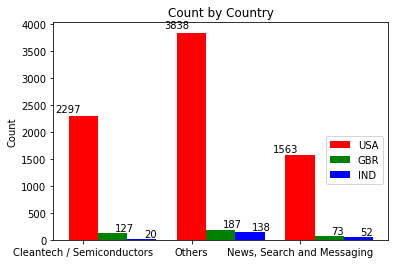

In [627]:
import numpy as np
import matplotlib.pyplot as plt

usa = list(top3_sector_by_country.loc[(top3_sector_by_country.country_code =='USA'),'count'])
gbr = top3_sector_by_country.loc[(top3_sector_by_country.country_code =='GBR'),'count']
india = top3_sector_by_country.loc[(top3_sector_by_country.country_code =='IND'),'count']


ind = np.arange(len(usa))  # the x locations for the groups
width = 0.27  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind , usa, width, 
                color='r', label='USA')
rects2 = ax.bar(ind + width, gbr, width, 
                color='g', label='GBR')

rects3 = ax.bar(ind + width*2,india , width, 
                color='b', label='IND')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Count by Country')
ax.set_xticks(ind)
ax.set_xticklabels(top3_sector_by_country.main_sector.unique().tolist())
ax.legend(bbox_to_anchor=(1, 0.5))


def autolabel(rects, xpos='center'):
    xpos = xpos.lower()  
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43} 

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "right")
autolabel(rects3, "right")
plt.show()

In [571]:
len(top9[top9['main_sector'].isnull()])

0

In [28]:
rounds2UniqeCompanies = (rounds2.groupby(rounds2['company_permalink'].str.lower(), as_index=False, sort=False))
print(len(rounds2UniqeCompanies))

66370


In [31]:
print(len(companies['permalink'].unique().tolist()))

66368


In [32]:
uniqeCompanies = (companies.groupby(companies['permalink'].str.lower(), as_index=False, sort=False))
print(len(uniqeCompanies))

66368
